In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis import run_h1_pricing_experiment
from visualization import plot_error_box
from analysis import run_abm_paths, estimate_sigma
from model import ABMModel 
plt.style.use('seaborn-v0_8-darkgrid')


cfg = dict(
    S0=100.0,
    dt=1/252,
    steps=252,
    n_fund=50,
    n_noise=50,
    n_chart=50,
    n_mm=4,
    fundamental_price=100.0,
    tick_size=0.1,
    impact=0.07,
    omega=1e-6,
    alpha_var=0.05,
    beta_var=0.94,
    fund_strength=0.1,
    chart_strength=0.6,
    chart_vol_sens=2.0,
    mom_window=20,
    vol_window=20,
    agent_noise=0.15,
    p01=0.02,
    p10=0.10,
    shock_rate=0.01,
    shock_impact=8.0,
    n_events_calm=400,
    n_events_stress=1200,
)

dt = cfg["dt"]
steps = cfg["steps"]
r = 0.0

df_bias, _, _ = run_h1_pricing_experiment(
    cfg=cfg,
    dt=dt,
    steps=steps,
    r=r,
    K_grid=K_grid,
    option_type="put",
    alpha_frac=0.5,
    n_paths=200,
    n_mc=40000,
    n_rep=10,
    seed0=0
)

## Гипотеза 2: BS систематически смещён относительно референса, TFBS ближе к 0
H0: TFBS-bias = BS-bias (нет улучшения)

H1: |TFBS-bias| < |BS-bias| (TFBS менее смещён → гипотеза F верна)

In [ ]:
from scipy.stats import ttest_1samp, ttest_rel, wilcoxon


df_bias["signed_err_bs"] = df_bias["bs"] - df_bias["ref"]
df_bias["signed_err_frac"] = df_bias["frac"] - df_bias["ref"]

overall_bias_bs = df_bias["signed_err_bs"].mean()
overall_bias_frac = df_bias["signed_err_frac"].mean()

abs_bias_bs = np.abs(df_bias["signed_err_bs"]).mean()
abs_bias_frac = np.abs(df_bias["signed_err_frac"]).mean()

t_bs, p_bs = ttest_1samp(df_bias["signed_err_bs"], 0.0)
t_frac, p_frac = ttest_1samp(df_bias["signed_err_frac"], 0.0)

bias_by_K = (
    df_bias
    .groupby("K")[["signed_err_bs", "signed_err_frac"]]
    .mean()
    .rename(columns={"signed_err_bs": "bias_bs", "signed_err_frac": "bias_frac"})
    .reset_index()
)

print("\n=== Hypothesis F: pricing bias vs reference ===")
print(f"Overall BS bias:   {overall_bias_bs:.6f}  (abs={abs_bias_bs:.6f}, t={t_bs:.3f}, p={p_bs:.3g})")
print(f"Overall TFBS bias: {overall_bias_frac:.6f}  (abs={abs_bias_frac:.6f}, t={t_frac:.3f}, p={p_frac:.3g})")

print()

t_pair, p_pair = ttest_rel(df_bias["signed_err_bs"], df_bias["signed_err_frac"])
t_abs, p_abs = ttest_rel(
    np.abs(df_bias["signed_err_bs"]),
    np.abs(df_bias["signed_err_frac"])
)
w_stat, w_p = wilcoxon(
    np.abs(df_bias["signed_err_bs"]),
    np.abs(df_bias["signed_err_frac"])
)
print(f"Paired t-test: t={t_pair:.4f}, p={p_pair:.4g}")
print(f"Paired abs-bias t-test: t={t_abs:.4f}, p={p_abs:.4g}")
print(f"Wilcoxon test (abs bias): stat={w_stat}, p={w_p:.4g}")



=== Hypothesis F: pricing bias vs reference ===
Overall BS bias:   -0.423360  (abs=0.423360, t=-8.050, p=1.6e-10)
Overall TFBS bias: -0.184272  (abs=0.204744, t=-5.869, p=3.72e-07)

Paired t-test: t=-9.3589, p=1.732e-12
Paired abs-bias t-test: t=7.8801, p=2.915e-10
Wilcoxon test (abs bias): stat=91.0, p=4.057e-09


Можем сделать вывод о наличии Bias в BS и TFBS, т.к. p-values очень малы (особенно для BS)

BS-модель существенно недооценивает put-опционы (средний bias ≈ −0.42, очень значимый), 
TFBS тоже даёт отрицательный bias, но примерно вдвое меньший по модулю (≈ −0.18). 
Основной недопрайсинг возникает в районе страйков 90–100, и там TFBS стабильно уменьшает систематическую ошибку, 
оставаясь существенно ближе к референсу ABM, чем классический BS.

Все три теста (парный t-тест, t-тест по абсолютному bias и Wilcoxon) дали крайне малые p-values, 
поэтому мы уверенно отвергаем нулевую гипотезу о равенстве bias BS и TFBS.

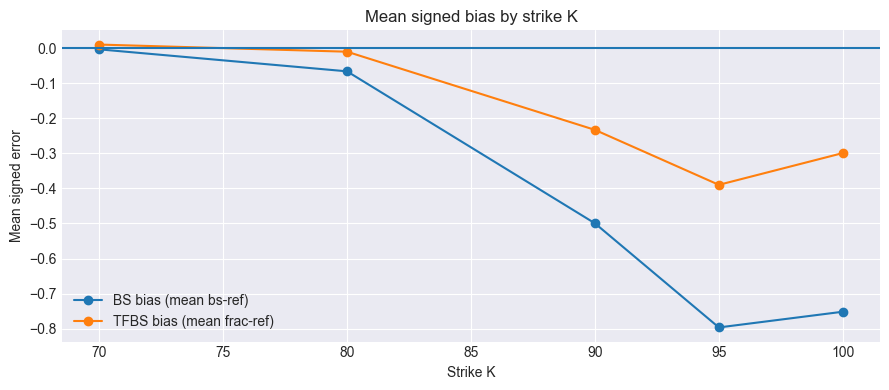

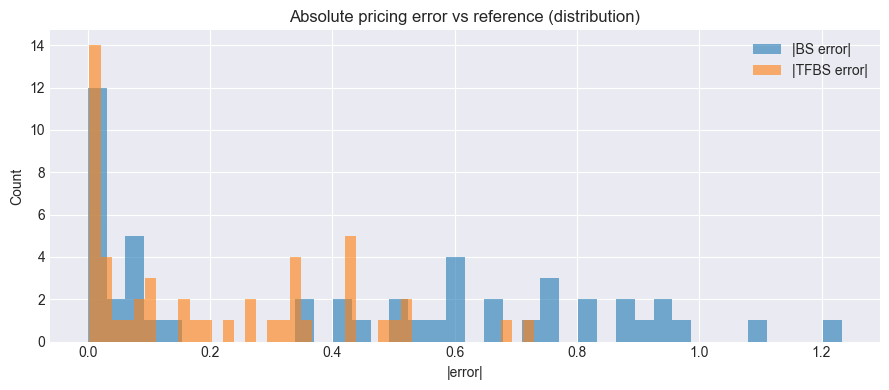

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

bias_by_K = (
    df_bias
    .groupby("K")[["signed_err_bs", "signed_err_frac"]]
    .mean()
    .rename(columns={"signed_err_bs": "bias_bs", "signed_err_frac": "bias_frac"})
    .reset_index()
    .sort_values("K")
)

plt.figure(figsize=(9, 4))
plt.plot(bias_by_K["K"].values, bias_by_K["bias_bs"].values, marker="o", label="BS bias (mean bs-ref)")
plt.plot(bias_by_K["K"].values, bias_by_K["bias_frac"].values, marker="o", label="TFBS bias (mean frac-ref)")
plt.axhline(0.0)
plt.title("Mean signed bias by strike K")
plt.xlabel("Strike K")
plt.ylabel("Mean signed error")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()


abs_bs = np.abs(df_bias["signed_err_bs"].values)
abs_fr = np.abs(df_bias["signed_err_frac"].values)
delta_abs = abs_bs - abs_fr

plt.figure(figsize=(9, 4))
plt.hist(abs_bs, bins=40, alpha=0.6, label="|BS error|")
plt.hist(abs_fr, bins=40, alpha=0.6, label="|TFBS error|")
plt.title("Absolute pricing error vs reference (distribution)")
plt.xlabel("|error|")
plt.ylabel("Count")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

## Hypothesis 3: TFBS gains are largest for longer maturities and extreme strikes

In [ ]:
def sample_positive_stable(alpha, size, rng): 
    alpha = float(alpha) 
    U = rng.uniform(0.0, np.pi, size=size) 
    W = rng.exponential(1.0, size=size) 
    part1 = np.sin(alpha * U) / (np.sin(U) ** alpha) 
    part2 = (np.sin((1.0 - alpha) * U) / W) ** (1.0 - alpha) 
return part1 * part2

def simulate_frac_and_bs_payoffs(S0, K, r, sigma, T, alpha, n_mc, seed):
    rng = np.random.default_rng(seed)
    S = sample_positive_stable(alpha, n_mc, rng)
    E = (T / np.maximum(S, 1e-16)) ** alpha
    Z = rng.normal(0.0, 1.0, size=n_mc)
    ST_frac = S0 * np.exp((r - 0.5 * sigma * sigma) * E + sigma * np.sqrt(E) * Z)
    ST_bs = S0 * np.exp((r - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * Z)
    disc = np.exp(-r * T)
    Y = disc * np.maximum(ST_frac - K, 0.0)
    X = disc * np.maximum(ST_bs - K, 0.0)
    return Y, X

def fractional_price_call_mc_cv(S0, K, r, sigma, T, alpha, n_mc, seed):
    Y, X = simulate_frac_and_bs_payoffs(S0, K, r, sigma, T, alpha, n_mc, seed)
    EX = bs_price_call(S0, K, r, sigma, T)
    Xc = X - np.mean(X)
    Yc = Y - np.mean(Y)
    varX = float(np.mean(Xc * Xc))
    if varX <= 0:
        return float(np.mean(Y))
    covYX = float(np.mean(Yc * Xc))
    b = covYX / varX
    Y_adj = Y - b * (X - EX)
    return float(np.mean(Y_adj))

def fractional_price_put_mc_cv(S0, K, r, sigma, T, alpha, n_mc, seed):
    Y, X = simulate_frac_and_bs_payoffs(S0, K, r, sigma, T, alpha, n_mc, seed)
    EX = bs_price_put(S0, K, r, sigma, T)
    disc = np.exp(-r * T)
    S0_arr = Y * 0.0 + S0
    ST_bs = S0_arr * 0.0 
    Y_put = disc * np.maximum(0.0, 0.0)

def simulate_frac_and_bs_payoffs_call(S0, K, r, sigma, T, alpha, n_mc, seed):
    rng = np.random.default_rng(seed)
    S = sample_positive_stable(alpha, n_mc, rng)
    E = (T / np.maximum(S, 1e-16)) ** alpha
    Z = rng.normal(0.0, 1.0, size=n_mc)
    ST_frac = S0 * np.exp((r - 0.5 * sigma * sigma) * E + sigma * np.sqrt(E) * Z)
    ST_bs = S0 * np.exp((r - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * Z)
    disc = np.exp(-r * T)
    Y = disc * np.maximum(ST_frac - K, 0.0)
    X = disc * np.maximum(ST_bs - K, 0.0)
    return Y, X

def simulate_frac_and_bs_payoffs_put(S0, K, r, sigma, T, alpha, n_mc, seed):
    rng = np.random.default_rng(seed)
    S = sample_positive_stable(alpha, n_mc, rng)
    E = (T / np.maximum(S, 1e-16)) ** alpha
    Z = rng.normal(0.0, 1.0, size=n_mc)
    ST_frac = S0 * np.exp((r - 0.5 * sigma * sigma) * E + sigma * np.sqrt(E) * Z)
    ST_bs = S0 * np.exp((r - 0.5 * sigma * sigma) * T + sigma * np.sqrt(T) * Z)
    disc = np.exp(-r * T)
    Y = disc * np.maximum(K - ST_frac, 0.0)
    X = disc * np.maximum(K - ST_bs, 0.0)
    return Y, X

def fractional_price_call_mc_cv(S0, K, r, sigma, T, alpha, n_mc, seed):
    Y, X = simulate_frac_and_bs_payoffs_call(S0, K, r, sigma, T, alpha, n_mc, seed)
    EX = bs_price_call(S0, K, r, sigma, T)
    Xc = X - np.mean(X)
    Yc = Y - np.mean(Y)
    varX = float(np.mean(Xc * Xc))
    if varX <= 0:
        return float(np.mean(Y))
    covYX = float(np.mean(Yc * Xc))
    b = covYX / varX
    Y_adj = Y - b * (X - EX)
    return float(np.mean(Y_adj))

def fractional_price_put_mc_cv(S0, K, r, sigma, T, alpha, n_mc, seed):
    Y, X = simulate_frac_and_bs_payoffs_put(S0, K, r, sigma, T, alpha, n_mc, seed)
    EX = bs_price_put(S0, K, r, sigma, T)
    Xc = X - np.mean(X)
    Yc = Y - np.mean(Y)
    varX = float(np.mean(Xc * Xc))
    if varX <= 0:
        return float(np.mean(Y))
    covYX = float(np.mean(Yc * Xc))
    b = covYX / varX
    Y_adj = Y - b * (X - EX)
    return float(np.mean(Y_adj))


In [19]:
def run_h3_tfbs_gains_surface(
    cfg_base,
    steps_grid,
    moneyness_grid,
    r,
    alpha_frac,
    n_paths,
    n_mc,
    n_rep,
    seed0,
    option_type="put",
):
    rows = []
    S0 = float(cfg_base["S0"])
    dt = float(cfg_base["dt"])

    for rep in range(int(n_rep)):
        rep_seed = int(seed0 + rep * 999)

        for steps in steps_grid:
            steps = int(steps)
            cfg = dict(cfg_base)
            cfg["steps"] = steps

            paths = run_abm_paths(cfg, n_paths=int(n_paths), seed0=rep_seed)
            sigma = float(estimate_sigma(paths, dt=dt))
            T = float(steps) * dt

            for m in moneyness_grid:
                m = float(m)
                K = float(S0 * m)

                if option_type == "call":
                    ref = float(reference_price_call(paths, K=K, r=r, T=T))
                    p_bs = float(bs_price_call(S0, K, r, sigma, T))
                    p_fr = float(
                        fractional_price_call_mc_cv(
                            S0, K, r, sigma, T,
                            alpha=alpha_frac,
                            n_mc=n_mc,
                            seed=rep_seed + int(1e6 * m) + steps,
                        )
                    )
                else:
                    ref = float(reference_price_put(paths, K=K, r=r, T=T))
                    p_bs = float(bs_price_put(S0, K, r, sigma, T))
                    p_fr = float(
                        fractional_price_put_mc_cv(
                            S0, K, r, sigma, T,
                            alpha=alpha_frac,
                            n_mc=n_mc,
                            seed=rep_seed + int(1e6 * m) + steps,
                        )
                    )

                e_bs = abs(p_bs - ref)
                e_fr = abs(p_fr - ref)
                imp = float(e_bs - e_fr)

                rows.append({
                    "rep": int(rep),
                    "steps": int(steps),
                    "T": float(T),
                    "m": float(m),
                    "abs_log_m": float(abs(np.log(m))),
                    "K": float(K),
                    "sigma": float(sigma),
                    "ref": float(ref),
                    "bs": float(p_bs),
                    "frac": float(p_fr),
                    "abs_err_bs": float(e_bs),
                    "abs_err_frac": float(e_fr),
                    "improvement": float(imp),
                })

    return pd.DataFrame(rows)


def summarize_h3_tfbs(df, n_T_bins=4, n_m_bins=6):
    d = df.copy()
    d["T_bin"] = pd.qcut(d["T"], q=int(n_T_bins), duplicates="drop")
    d["m_bin"] = pd.qcut(d["abs_log_m"], q=int(n_m_bins), duplicates="drop")

    surf = (
        d.groupby(["T_bin", "m_bin"])["improvement"]
        .agg(["mean", "median", "count", lambda x: float(np.mean(np.array(x) > 0.0))])
        .reset_index()
    )
    surf = surf.rename(columns={"<lambda_0>": "share_improvement_pos"})

    byT = d.groupby("T")["improvement"].agg(["mean", "median", "count"]).reset_index()
    byM = d.groupby("abs_log_m")["improvement"].agg(["mean", "median", "count"]).reset_index()

    top = d.sort_values("improvement", ascending=False).head(15)[["rep", "T", "m", "K", "improvement", "abs_err_bs", "abs_err_frac"]]
    bot = d.sort_values("improvement", ascending=True).head(15)[["rep", "T", "m", "K", "improvement", "abs_err_bs", "abs_err_frac"]]

    return surf, byT, byM, top, bot

def h3_regression_simple(df):
    X = np.column_stack([
        np.ones(len(df)),
        df["abs_log_m"].values,
        df["T"].values,
        (df["abs_log_m"].values * df["T"].values),
    ])
    y = df["improvement"].values
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    yhat = X @ beta
    resid = y - yhat
    n, k = X.shape
    s2 = float((resid @ resid) / max(1, n - k))
    XtX_inv = np.linalg.inv(X.T @ X)
    se = np.sqrt(np.diag(s2 * XtX_inv))

    out = {
        "beta_intercept": float(beta[0]),
        "beta_abs_log_m": float(beta[1]),
        "beta_T": float(beta[2]),
        "beta_interaction_abs_log_m_x_T": float(beta[3]),
        "se_intercept": float(se[0]),
        "se_abs_log_m": float(se[1]),
        "se_T": float(se[2]),
        "se_interaction": float(se[3]),
    }
    return out


In [ ]:
steps_grid = [126, 252, 504, 756]
moneyness_grid = [0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]

df_h3 = run_h3_tfbs_gains_surface(
    cfg_base=cfg,
    steps_grid=steps_grid,
    moneyness_grid=moneyness_grid,
    r=0.0,
    alpha_frac=0.85,
    n_paths=80,
    n_mc=4000,
    n_rep=5,
    seed0=123,
    option_type="put",
)

surf, byT, byM, top, bot = summarize_h3_tfbs(df_h3, n_T_bins=4, n_m_bins=6)
reg = h3_regression_simple(df_h3)

t=200  bb=112.80  ba=113.10  sp=0.300  db=14.00  da=9.00  trades_step=27
t=200  bb=98.90  ba=99.20  sp=0.300  db=13.00  da=45.00  trades_step=2
t=200  bb=110.20  ba=110.30  sp=0.100  db=15.00  da=1.00  trades_step=25
t=200  bb=97.00  ba=97.40  sp=0.400  db=57.00  da=63.00  trades_step=1
t=200  bb=90.80  ba=91.20  sp=0.400  db=60.00  da=59.00  trades_step=0
t=200  bb=106.70  ba=106.90  sp=0.200  db=15.00  da=2.00  trades_step=30
t=200  bb=83.90  ba=84.10  sp=0.200  db=4.00  da=15.00  trades_step=31
t=200  bb=97.30  ba=97.60  sp=0.300  db=13.00  da=21.00  trades_step=23
t=200  bb=106.30  ba=106.60  sp=0.300  db=15.00  da=44.00  trades_step=23
t=200  bb=102.60  ba=103.30  sp=0.700  db=7.00  da=5.00  trades_step=14
t=200  bb=92.90  ba=93.10  sp=0.200  db=1.00  da=52.00  trades_step=0
t=200  bb=107.40  ba=107.80  sp=0.400  db=60.00  da=59.00  trades_step=1
t=200  bb=99.10  ba=99.90  sp=0.800  db=6.00  da=21.00  trades_step=13
t=200  bb=91.00  ba=91.40  sp=0.400  db=61.00  da=57.00  trades_s

/var/folders/5j/cxq1m23j1k77h961fvg0f3v00000gn/T/ipykernel_1589/2367395696.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d.groupby(["T_bin", "m_bin"])["improvement"]


In [43]:
from scipy.stats import norm
from math import sqrt

def _ols_beta(df):
    X = np.column_stack([
        np.ones(len(df)),
        df["abs_log_m"].values,
        df["T"].values,
        (df["abs_log_m"].values * df["T"].values),
    ])
    y = df["improvement"].values
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    return beta

def _cluster_bootstrap_reps(df, B=5000, seed=1):
    rng = np.random.default_rng(seed)
    reps = np.array(sorted(df["rep"].unique()))
    betas = np.zeros((B, 4), dtype=float)
    for b in range(B):
        reps_b = rng.choice(reps, size=len(reps), replace=True)
        d_b = pd.concat([df[df["rep"] == r] for r in reps_b], ignore_index=True)
        betas[b] = _ols_beta(d_b)
    return betas

def _summ_ci_p(v):
    v = np.asarray(v, dtype=float)
    ci_lo, ci_hi = np.quantile(v, [0.025, 0.975])
    p_one_sided_gt0 = float(np.mean(v <= 0.0))
    return float(v.mean()), (float(ci_lo), float(ci_hi)), p_one_sided_gt0

def _two_prop_ztest(posA, nA, posB, nB):
    pA = posA / nA
    pB = posB / nB
    p_pool = (posA + posB) / (nA + nB)
    se = sqrt(max(1e-12, p_pool * (1 - p_pool) * (1 / nA + 1 / nB)))
    z = (pA - pB) / se
    p_one_sided = float(1 - norm.cdf(z))
    return float(pA), float(pB), float(z), p_one_sided

def _trend_test_Tbin_from_surf(surf):
    d = surf.copy()
    d["pos"] = (d["share_improvement_pos"] * d["count"]).round().astype(int)

    agg = d.groupby("T_bin", observed=False)[["pos", "count"]].sum().reset_index()

    def mid_from_interval(s):
        s = str(s).strip()
        a, b = s[1:-1].split(",")
        return 0.5 * (float(a) + float(b))

    agg["T_mid"] = agg["T_bin"].apply(mid_from_interval)
    agg = agg.sort_values("T_mid").reset_index(drop=True)

    x = agg["pos"].to_numpy()
    n = agg["count"].to_numpy()
    w = np.arange(1, len(agg) + 1, dtype=float)

    N = n.sum()
    X = x.sum()
    p_hat = X / N
    wbar = (n * w).sum() / N
    num = ((w - wbar) * (x - n * p_hat)).sum()
    den = np.sqrt(max(1e-12, p_hat * (1 - p_hat) * (n * (w - wbar) ** 2).sum()))
    Z = num / den
    p_one_sided = float(1 - norm.cdf(Z))
    return agg, float(Z), p_one_sided

def _format_overall(d):
    n = int(len(d))
    n_reps = int(d["rep"].nunique())
    win = d["win"].astype(int)
    pos = int(win.sum())
    neg = int(n - pos)
    share = float(pos / n)
    mean_imp = float(d["improvement"].mean())
    med_imp = float(d["improvement"].median())
    p0 = 0.5
    se = sqrt(max(1e-12, p0 * (1 - p0) / n))
    z = (share - p0) / se
    p_one = float(1 - norm.cdf(z))

    lines = [
        f"TFBS wins (improvement>0): {pos}/{n} = {share:.1%}  (loses: {neg}/{n} = {(1-share):.1%})",
        f"Mean improvement: {mean_imp:+.6f}   |   Median improvement: {med_imp:+.6f}",
        f"Replicates: {n_reps}   |   Total points: {n}",
        f"Sign test vs 50% wins (one-sided): z={z:.3f}, p={p_one:.6g}",
    ]
    return "\n".join(lines)

def h3_run_tests(df_h3, surf=None, B=5000, seed=1, q_long=0.75, q_far=0.75):
    d = df_h3.copy()
    needed = {"rep", "T", "abs_log_m", "improvement"}
    miss = needed - set(d.columns)
    if miss:
        raise ValueError(f"df_h3 missing columns: {miss}")

    d["win"] = (d["improvement"].values > 0.0).astype(int)

    betas = _cluster_bootstrap_reps(d, B=B, seed=seed)
    boot = {}
    names = ["beta_intercept", "beta_abs_log_m", "beta_T", "beta_interaction"]
    for j, nm in enumerate(names):
        mean, ci, p1 = _summ_ci_p(betas[:, j])
        boot[nm] = {"mean": mean, "ci95": ci, "p_one_sided_gt0": p1}

    T_thr = float(d["T"].quantile(q_long))
    m_thr = float(d["abs_log_m"].quantile(q_far))
    is_long = d["T"].values >= T_thr
    is_far = d["abs_log_m"].values >= m_thr

    A = d[is_long & is_far]
    Bdf = d[~(is_long & is_far)]

    posA, nA = int(A["win"].sum()), int(len(A))
    posB, nB = int(Bdf["win"].sum()), int(len(Bdf))
    pA, pB, z, p_one = _two_prop_ztest(posA, nA, posB, nB)

    group_test = {
        "T_thr_q": q_long,
        "abs_log_m_thr_q": q_far,
        "T_thr": T_thr,
        "abs_log_m_thr": m_thr,
        "Long&Far": {"pos": posA, "n": nA, "share": pA},
        "Other": {"pos": posB, "n": nB, "share": pB},
        "z_one_sided": z,
        "p_value_one_sided_pA_gt_pB": p_one,
    }

    trend = None
    if surf is not None:
        aggTbin, Z, p_tr = _trend_test_Tbin_from_surf(surf)
        trend = {"by_T_bin": aggTbin, "Z": Z, "p_one_sided_increasing": p_tr}

    overall_pretty = _format_overall(d)

    return {
        "overall_pretty": overall_pretty,
        "bootstrap_ols_by_rep": boot,
        "longfar_vs_other": group_test,
        "trend_Tbin_from_surf": trend,
    }

res = h3_run_tests(df_h3, surf=surf, B=5000, seed=1)


In [44]:
print("\n=== H3 tests: overall ===")
print(res["overall_pretty"])


=== H3 tests: overall ===
TFBS wins (improvement>0): 96/140 = 68.6%  (loses: 44/140 = 31.4%)
Mean improvement: +0.020280   |   Median improvement: +0.011435
Replicates: 5   |   Total points: 140
Sign test vs 50% wins (one-sided): z=4.395, p=5.54369e-06


In [45]:
print("\n=== H3 tests: cluster bootstrap OLS by rep (one-sided H1: coef > 0) ===")
for k, v in res["bootstrap_ols_by_rep"].items():
    ci = v["ci95"]
    print(f"{k:>18}: mean={v['mean']:+.6f}, CI95=({ci[0]:+.6f},{ci[1]:+.6f}), p_one_sided_gt0={v['p_one_sided_gt0']:.6f}")


=== H3 tests: cluster bootstrap OLS by rep (one-sided H1: coef > 0) ===
    beta_intercept: mean=-0.039167, CI95=(-0.124640,+0.047590), p_one_sided_gt0=0.850600
    beta_abs_log_m: mean=+0.103959, CI95=(-0.212273,+0.434814), p_one_sided_gt0=0.270400
            beta_T: mean=+0.037613, CI95=(+0.006079,+0.064441), p_one_sided_gt0=0.005600
  beta_interaction: mean=-0.069492, CI95=(-0.202820,+0.053663), p_one_sided_gt0=0.850600


Рост срока T статистически значимо увеличивает improvement. То есть часть H3 “эффект сильнее на больших T” подтверждается.

In [46]:
if res["trend_Tbin_from_surf"] is not None:
    tr = res["trend_Tbin_from_surf"]
    print("\n=== H3 tests: trend in win-share across T_bin (Cochran–Armitage, one-sided increasing) ===")
    print(tr["by_T_bin"].to_string(index=False))
    print(f"Z={tr['Z']:.4f}, p(one-sided)={tr['p_one_sided_increasing']:.6f}")


=== H3 tests: trend in win-share across T_bin (Cochran–Armitage, one-sided increasing) ===
         T_bin  pos  count  T_mid
(0.499, 0.875]   15     35 0.6870
  (0.875, 1.5]   22     35 1.1875
   (1.5, 2.25]   30     35 1.8750
   (2.25, 3.0]   29     35 2.6250
Z=4.0709, p(one-sided)=0.000023


Вероятность того, что TFBS лучше BS, статистически значимо растёт с T (монотонный тренд). Это прямое и очень сильное подтверждение H3 по maturity.

H3 подтверждается в части “длиннее срок → TFBS помогает чаще и сильнее” (trend p=2.3e-05 и beta_T>0 с бутстрап-CI выше 0). \
Часть “экстремальные страйки усиливают эффект на больших T” по этим данным не доказана

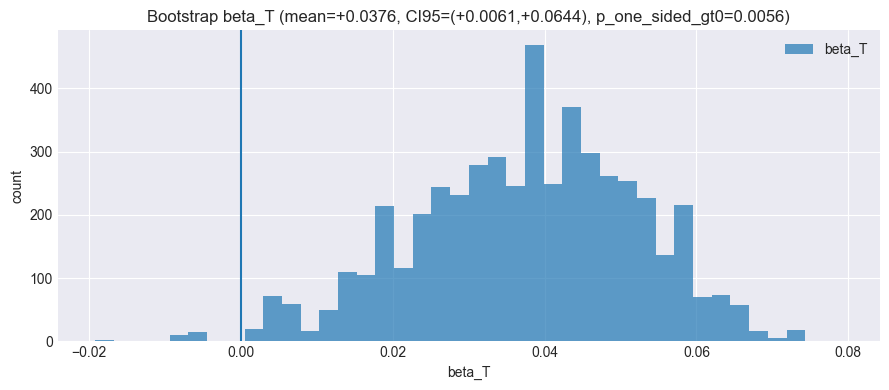

In [48]:
import numpy as np
import matplotlib.pyplot as plt

def _wilson_ci(k, n, alpha=0.05):
    if n <= 0:
        return (np.nan, np.nan)
    z = norm.ppf(1 - alpha/2)
    phat = k / n
    denom = 1 + z*z/n
    center = (phat + z*z/(2*n)) / denom
    half = z * np.sqrt((phat*(1-phat)/n) + (z*z/(4*n*n))) / denom
    return float(center - half), float(center + half)

def plot_h3_graphs(df_h3, surf, res, B=5000, seed=1):
    d = df_h3.copy()
    d["win"] = (d["improvement"].values > 0.0).astype(int)

    betas = _cluster_bootstrap_reps(d, B=B, seed=seed)
    beta_T = betas[:, 2]
    beta_int = betas[:, 3]

    plt.figure(figsize=(9, 4))
    plt.hist(beta_T, bins=40, alpha=0.7, label="beta_T")
    plt.axvline(0.0)
    m, (lo, hi), p1 = _summ_ci_p(beta_T)
    plt.title(f"Bootstrap beta_T (mean={m:+.4f}, CI95=({lo:+.4f},{hi:+.4f}), p_one_sided_gt0={p1:.3g})")
    plt.xlabel("beta_T")
    plt.ylabel("count")
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

   

plot_h3_graphs(df_h3=df_h3, surf=surf, res=res, B=5000, seed=1)
